# Autoregressive Point-Processes as Latent State-Space Models

This is an fork of the notebook `ARPPGLM_moment_equations`, and includes (experimental!) evaluation of an (approximate) Gamma moment closure. Please refer to `ARPPGLM_moment_equations` at the official document to accompany the paper.

## Configure notebook

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import division
from __future__ import print_function

# Load scipy/numpy/matplotlib
from   scipy.linalg import expm
import matplotlib.pyplot as plt
from   pylab import *

# Configure figure resolution
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['savefig.dpi'   ] = 100

# Get subroutines
from izh       import * # Routines for sampling Izhikevich neurons
from plot      import * # Misc. plotting routines
from glm       import * # GLM fitting
from arppglm   import * # Sampling and integration
from utilities import * # Other utilities

figure_prefix = "RuleSanguinetti2018_figure_"

# Case study: phasic bursting Izhikevich neuron

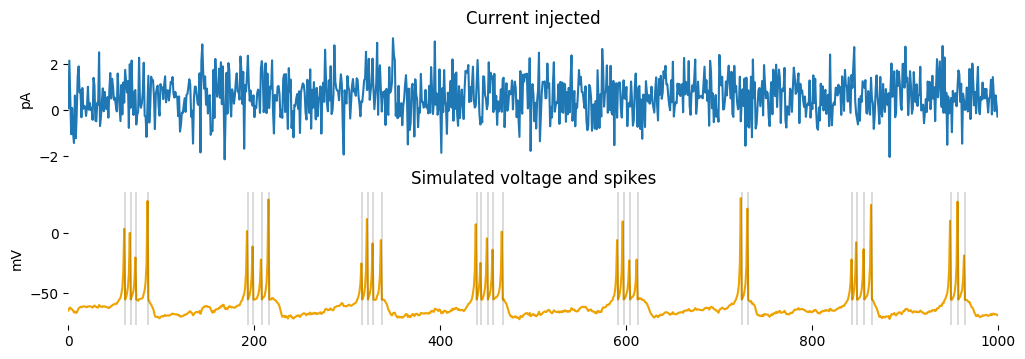

In [2]:
# Izhikevich parameters
izh   = (0.02,0.25,-55,0.05) # a, b, c, d
dt    = 1.0    # time step
nplot = 1000   # time points for plotting
I     = 0.6    # current drive

# Stimulus with synaptic noise
stimulus = randn(nplot)*sqrt(I)+I

# Plot current input
subplot(311); plot(stimulus)
xlim(0,nplot); nox(); noaxis(); ylabel('pA')
title('Current injected')

# Solve Izh model
state = sim_izh(*izh,stimulus)

# Plot voltage and spikes
subplot(312); plot(state[:,1],color=OCHRE);
xlim(0,nplot); noaxis(); addspikes(state[:,-1]); ylabel('mV');
title('Simulated voltage and spikes');

## Train model on pulses

GLMs can emulate neural firing, but have limited ability to generalize outside of the dynamical regime in which they are trained (Weber & Pillow 2017). For this reason, we train with stimuli that elicit phasic bursting responses (tonic bursting seems to be possible at higher stimulation currents, but interferes with the GLMs ability to model the phasic bursting regime).

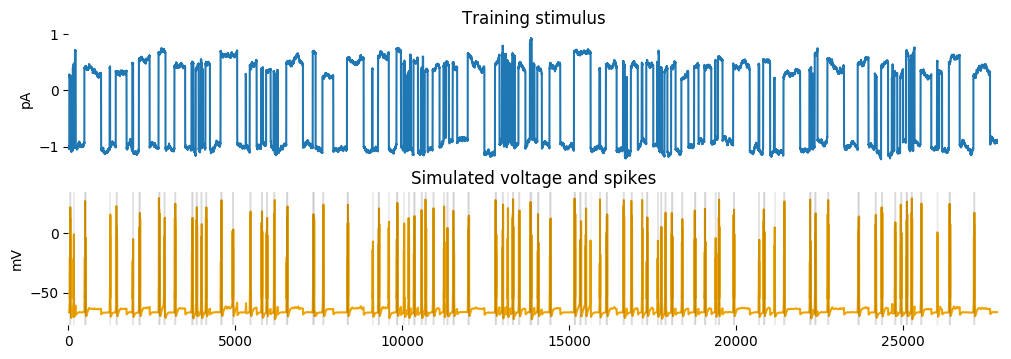

In [3]:
# Define pulse training stimuli
offset     = -1     # Baseline current (picoamps)
min_amp    = 0.3    # Smallest current step (picoamps)
max_amp    = 0.7    # Largest  current step (picoamps)
min_pulse  = 10     # Shortest pulse duration (ms)
max_pulse  = 500    # Longest  pulse duration (ms)
amplitudes = exp(linspace(log(min_amp),log(max_amp),10))
durationms = int32(exp(linspace(log(min_pulse),log(max_pulse),10)))
stimulus   = pulse_sequence(amplitudes,durationms,offset)

# Define Ornstein–Uhlenbeck (OU) process training noise 
ssvar     = 0.005          # Noise steady-state viariance (ln(pA)^2)
tau       = 200            # Noise correlation time constant (ms)
noisevar  = 2*ssvar/tau    # Noise fluctuation variance
sigma     = sqrt(noisevar) # Noise flucutation standard deviation
stimulus  += sample_ou_process(0,sigma,tau,dt,len(stimulus),ntrial=1).ravel()

# Total number of training samples
ntrain     = len(stimulus)

# Plot training stimulus
subplot(311); plot(stimulus)
nox(); noaxis(); xlim(0,ntrain); ylabel('pA')
title('Training stimulus');

# Solve Izh model and get voltage and spikes
state = sim_izh(*izh,stimulus,dt=dt)
v,Y   = state[:,1],state[:,2]

# Plot voltage and spikes
subplot(312); plot(v,color=OCHRE); addspikes(Y,lw=0.05);
noaxis(); xlim(0,ntrain); ylabel('mV');
title('Simulated voltage and spikes');

# Fit GLM to Izhikevich model

### Define history basis functions

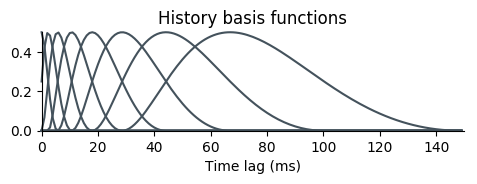

In [4]:
# Define history basis functions
N = 150   # Duration of history filter
K = 8     # number of basis elements
D = 5     # Duration of shortest basis element
B = make_cosine_basis(K,N,D,normalize=False)

# Plot history basis functions
subplot(421)
plot(B.T,color=BLACK,clip_on=False);
xlim(0,N); ylim(0,0.5); simpleaxis()
xlabel('Time lag (ms)')
title('History basis functions')

### Generate stimulus and spiking history training features

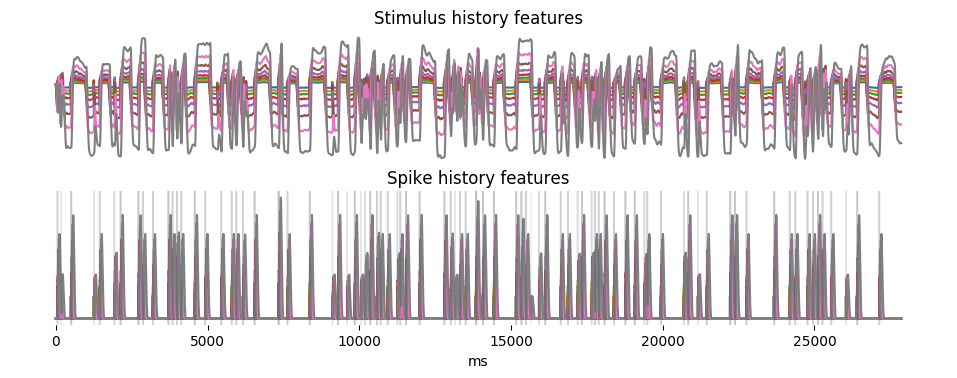

In [5]:
# Build stimulus filter (history trace of I)
# These are needed to model subthreshold dynamics
Bh = array([convolve(b,stimulus) for b in B]).T[:ntrain]
Bp = concatenate([zeros((K,1)),B],axis=1)
By = array([convolve(b,Y) for b in Bp]).T[:ntrain]

# Plot stimulus history features
subplot(311); plot(Bh); noxyaxes();
title('Stimulus history features');

# Plot spike history features
subplot(312); plot(By);
for t in find(Y>0): axvline(t,lw=0.1,color=BLACK)
noaxis(); noy(); xlabel('ms');
title('Spike history features');

## Train model

In [6]:
# Compose feature vector and fit GLM
X = concatenate([By,Bh],axis=1)
m,bhat = fitGLM(X,Y)

# Unpack parameters, separating into stimulus vs. autohistory components
bhat_spikehist = bhat[:K]
bhat_stimulus  = bhat[K:]
beta = bhat[:K].reshape(K,1)

### Pulse stimulus for demonstration

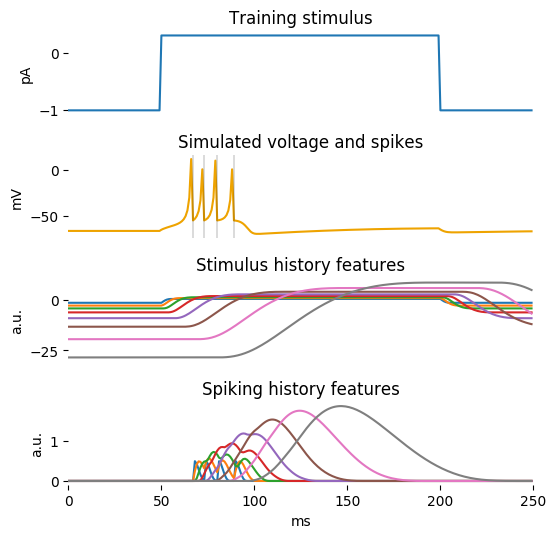

In [7]:
# define pulse pulse
duration = 150   # Pulse duration (ms)
padding  = 50    # Pulse padding (ms)
burnin   = 200   # Time for Izhikevich model to settle (ms)
current  = 0.3   # Pulse current (pA)

# total length of pulse stimulus (ms)
npulse = duration + 2*padding 

# Build pulse stimulus
pulse_stimulus = zeros(npulse+burnin) + offset
pulse_stimulus[burnin+padding:burnin+padding+duration] = current

figure(figsize=(6,6))

# Plot pulse stimulus
subplot(411); plot(pulse_stimulus[burnin:])
nox(); noaxis(); xlim(0,npulse); ylabel('pA')
title('Training stimulus');

# Solve Izh model
pulse_state = sim_izh(*izh,pulse_stimulus,dt=dt)
pulse_v = pulse_state[burnin:,1]
pulse_Y = pulse_state[burnin:,2]

# Plot pulse model spiking 
subplot(412); plot(pulse_v,color=OCHRE);
addspikes(pulse_Y)
nox(); noaxis(); xlim(0,npulse); ylabel('mV');
title('Simulated voltage and spikes');

# Bulid GLM filter responses
pulse_Bh = array([convolve(b,pulse_stimulus) for b in B ]).T[burnin-1:][:npulse,:]
pulse_By = array([convolve(b,pulse_Y       ) for b in Bp]).T[:npulse,:]
pulse_X  = concatenate([pulse_By,pulse_Bh],axis=1)

# Plot pulse stimulus history features 
subplot(413); plot(pulse_Bh);
xlim(0,npulse); nox(); noaxis(); ylabel('a.u.')
title('Stimulus history features')

# Plot pulse spiking history features 
subplot(414); plot(pulse_By);
xlim(0,npulse); noaxis(); xlabel('ms'); ylabel('a.u.')
title('Spiking history features')
subplots_adjust(hspace=0.5)
plt.draw()

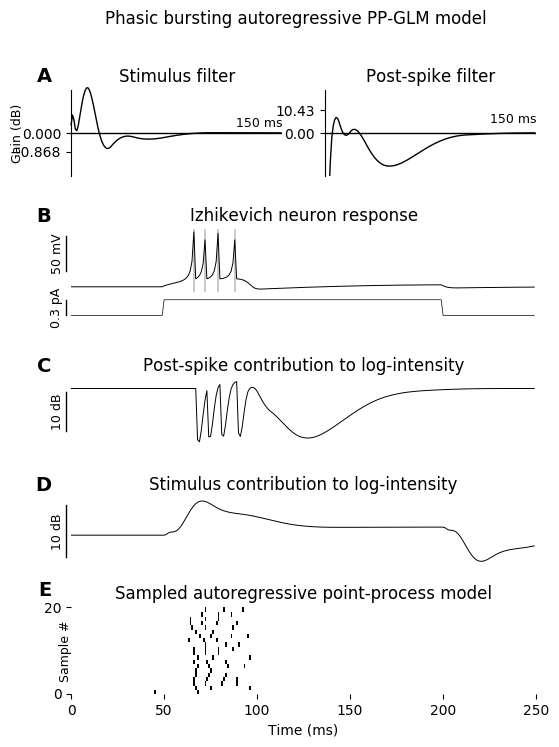

In [8]:
figure(figsize=(6,8))
# Use dB for log-units
dB    = log10(e)*10

def labeltime():
    ''' x-axis time label  '''
    text(xlim()[1],0+pixels_to_yunits(5),'%d ms'%N,
        horizontalalignment='right',
        verticalalignment='bottom',
        fontsize=9)

def doaxis():
    ''' common axis settings for these plots '''
    axhline(0,color='k',lw=1)
    xlim(0,N); nox(); nicey(); simpleraxis(); labeltime()
    
# Plot stimulus history filter
stimyscale = 2
a1=subplot2grid((5,2),(0,0),colspan=1)
plot(bhat_stimulus.dot(B)*dB,color='k',lw=1,clip_on=False)
doaxis()
ylim(-stimyscale,stimyscale); 
ylabel('Gain (dB)',fontsize=9); fudgey(10)
title('Stimulus filter')
subfigurelabel('A')

# Plot spike history filter
histyscale = 20
a1=subplot2grid((5,2),(0,1),colspan=1)
plot(bhat_spikehist.dot(B)*dB,color='k',lw=1)
doaxis()
ylim(-histyscale,histyscale)
title('Post-spike filter')

# Illustrate neuron stimulus and response
a2=subplot2grid((5,2),(1,0),colspan=2)
plot(pulse_v,'k',lw=0.7)
draw()
yl = ylim()
for t in find(pulse_Y)-1:
    plot([t,t],yl,color='k',lw=0.3)
height = abs(diff(yl)*0.25)
lower  = yl[0]-height*1.5
ii     = pulse_stimulus[burnin:][:npulse]
ii     = (ii-min(ii))/(max(ii)-min(ii))
plot(ii*height+lower,color='k',lw=0.5,clip_on=False)
yscalebar(yl[1]-35,50,'50 mV'); 
yscalebar(height*0.5+lower,height,'%0.1f pA'%current)
xlim(0,npulse); ylim(lower,yl[1]); noxyaxes()
title('Izhikevich neuron response')
subfigurelabel('B')

# Spike history contribution
a3=subplot2grid((5,2),(2,0),colspan=2)
plot(bhat_spikehist.dot(pulse_By.T),color='k',lw=0.7)
xlim(0,npulse); yscalebar(mean(ylim()),10,'10 dB'); noxyaxes()
title('Post-spike contribution to log-intensity')
subfigurelabel('C')

# Stimulus contribution
a4=subplot2grid((5,2),(3,0),colspan=2)
plot(bhat_stimulus.dot(pulse_Bh.T),color='k',lw=0.7)
xlim(0,npulse); yscalebar(mean(ylim()),10,'10 dB'); noxyaxes()
title('Stimulus contribution to log-intensity')
subfigurelabel('D')

# Sample the spiking response of the GLM
a5=subplot2grid((5,2),(4,0),colspan=2)
nsample = 20
stim    = m + bhat_stimulus.dot(pulse_Bh.T)
ysamp,logratesamp = ensemble_sample(stim,B,beta,nsample)
pcolormesh(1-ysamp.T,cmap="gray")
noaxis(); xticks(arange(0,251,50)); yticks([0,nsample],['0','%s'%nsample])
xlabel('Time (ms)'); ylabel('Sample #',fontsize=9); fudgey(20)
title('Sampled autoregressive point-process model')
subfigurelabel('E',dy=10)

# Make final adjustments
plt.draw()
subplots_adjust(hspace=0.5)
nudge_axis_y(-10,a2); adjust_axis_height_pixels(20,a3); 
nudge_axis_y(-10,a3); adjust_axis_height_pixels(20,a4)
suptitle('Phasic bursting autoregressive PP-GLM model')

# Construct low-dimensional system for history process

If the history basis is chosen suitably, the resuling linear system closely approximates the history basis. One can also use a linear system for the history filter form the outset, e.g. a collection of decaying exponential basis functions, enabeling an exact model. Since histor bases are commonly used, and the filtering approach is discussed elsewhere, we demonstrate the low-dimensional delay-line projection here. 

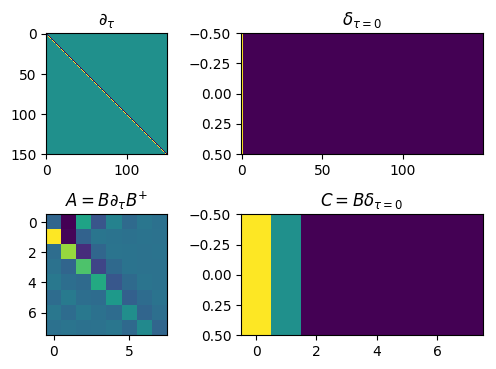

In [9]:
# Create discrete differentiation operator
Dtau = -eye(N) + eye(N,k=-1)
# Create delta operator (to inject signal into delay line)
S = zeros((N,1))
S[0,0] = 1
# Perform a change of basis from function space into the basis projection B
A = B.dot(Dtau).dot(pinv(B))
C = B.dot(S)

# Plot matrices
figure(figsize=(8,4)); 
subplot(221); imshow(Dtau);           title('$\partial_\\tau$')
subplot(222); imshow(S.T,aspect=N/2); title('$\delta_{\\tau=0}$')
subplot(223); imshow(A);              title('$A = B \partial_\\tau B^{+}$')
subplot(224); imshow(C.T,aspect=K/2); title('$C = B \delta_{\\tau=0}$')
subplots_adjust(hspace=0.5,wspace=-0.3)

### Show approximated filter impulse response

([<matplotlib.axis.XTick at 0x7f0591d4f5c0>,
 <a list of 2 Text xticklabel objects>)

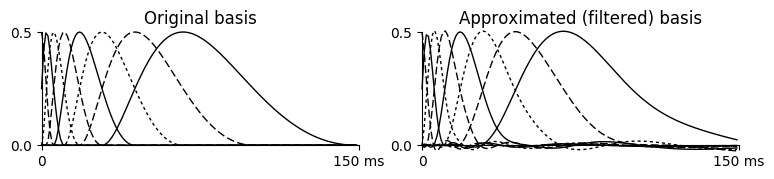

In [10]:
figure(figsize=(9,1.5))
styles = ['--','-',':']

impulse = zeros(N)
impulse[0]=1

subplot(121)
for i,b in enumerate(array([convolve(b,impulse) for b in B])):
    plot(b[:N],lw=1,linestyle=styles[i%len(styles)],color='k',clip_on=False)
simpleaxis(); xlim(0,N); ylim(0,.5); nicexy()
title('Original basis')
xticks([0,150],['0','150 ms'])

filtered = linfilter(A,C,impulse)
subplot(122)
for i,b in enumerate(filtered.T):
    plot(b[:N],lw=1,linestyle=styles[i%len(styles)],color='k',clip_on=False)
simpleaxis(); xlim(0,N); ylim(0,.5); nicexy()
title('Approximated (filtered) basis')
xticks([0,150],['0','150 ms'])

# Estimate single-time marginal log-intensity and varience using several different procedures



In [11]:
# 2000 for quick demo, set to 10000 or higher for more accuracy
NSAMPLE = 2000 

# "True" sample from point process model
# Samples are noisy if NSAMPLE is low, box-filter to denoise a bit
demo_logxpp,demo_logvpp,_,_ = ensemble_sample_moments(stim,B,beta,M=NSAMPLE)
demo_lxpp,demo_lvpp = box_filter(demo_logxpp,5), box_filter(demo_logvpp,5)
print('Sampled from true point process')

# Sample from langevin approximation of point process
# Samples are noisy if NSAMPLE is low, box-filter to denoise a bit
demo_logxlv,demo_logvlv,_,_  = langevin_sample_moments(stim,A,beta,C,M=NSAMPLE)
demo_lxlv,demo_lvlv = box_filter(demo_logxlv,5), box_filter(demo_logvlv,5)
print('Sampled from Langevin approximation to point process')

Sampled from true point process
Sampled from Langevin approximation to point process


In [12]:
# Estimate moments from mean-field and linear noise approximation
demo_logxmf,demo_logvmf,_,_ = integrate_moments(stim,A,beta,C,
                                                method     = "LNA",
                                                int_method = "euler")
print('Integrated moments using LNA')

# Only first two moments of rate are used for filtering
demo_logxso,demo_logvso,_,_ = integrate_moments(stim,A,beta,C,
                                                method     = "second_order",
                                                int_method = "euler")
print('Integrated moments using second-order moment closure')

# Estimate using moment closure
demo_logxmc,demo_logvmc,_,_ = integrate_moments(stim,A,beta,C,
                                                method     = "moment_closure",
                                                int_method = "euler")
print('Integrated moments using Gaussian moment closure')

# Estimate using gamma (approximate) moment closure
demo_logxgg,demo_logvgg,_,_ = integrate_moments(stim,A,beta,C,
                                                method     = "approximate_gamma",
                                                int_method = "euler")
print('Integrated moments using exp-gamma moment closure')

Integrated moments using LNA
Integrated moments using second-order moment closure
Integrated moments using Gaussian moment closure
Integrated moments using exp-gamma moment closure


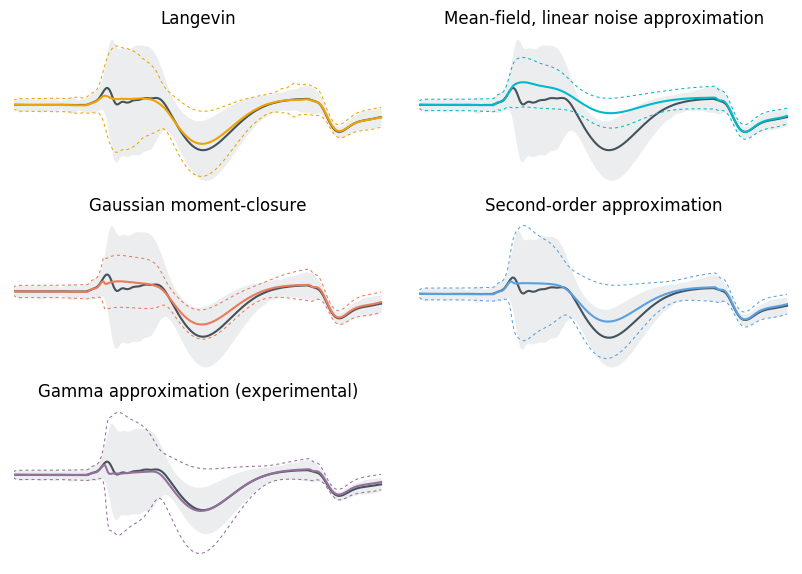

In [13]:
figure(figsize=(10,7))

# Plot sampled point process against sampled Langevin
subplot(321)
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_lxlv,demo_lvlv,OCHRE,filled=0)
xlim(0,npulse); noxyaxes()
title('Langevin')

# Plot LNA against sampled Langevin
subplot(322)
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_logxmf,demo_logvmf,TURQUOISE,filled=0)
xlim(0,npulse); noxyaxes()
title('Mean-field, linear noise approximation')

# Plot moment-closure against sampled Langevin
subplot(323)
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_logxmc,demo_logvmc,RUST,filled=0)
xlim(0,npulse); noy(); noxyaxes()
title('Gaussian moment-closure')

# Plot second-order
subplot(324)
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_logxso,demo_logvso, AZURE,filled=0)
xlim(0,npulse); noy(); noxyaxes();
title('Second-order approximation')

# Approximate Gamma moment closure
subplot(325)
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_logxgg,demo_logvgg, MAUVE,filled=0)
xlim(0,npulse); noy(); noxyaxes();
title('Gamma approximation (experimental)')

subplots_adjust(wspace=0.1,hspace=0.2)

# Demonstration pulse sequence

Construct a more "naturalistic" intput stimulus

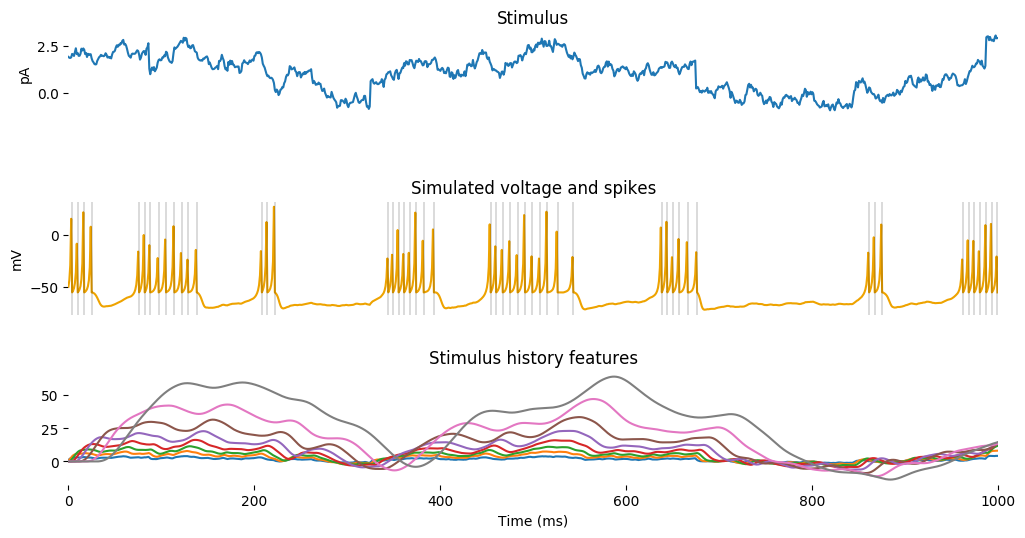

In [14]:
# Random pulse sequence
offset         = -0.5
pulse_stimulus = pulse_sequence(linspace(0.5,1.0,5),int32(linspace(50,500,7)),offset)

# OU process defining additional Gaussian noise
ntrain    = len(pulse_stimulus)
ssvar     = 1
tau       = 100
noisevar  = 2*ssvar/tau
sigma     = sqrt(noisevar)
noise2    = sample_ou_process(0,sigma,tau,dt,ntrain,ntrial=1).ravel()

# Combine pulses with noise, apply synaptic filter
dstimulus = pulse_stimulus + noise2
nstim     = 1000
dstimulus = dstimulus[:nstim*2]

# Plot demo stimulus
subplot(411); plot(dstimulus[nstim:])
xlim(0,nstim); ylabel('pA'); noaxis(); nox()
title('Stimulus')

# Solve Izh model
dstate = sim_izh(*izh,dstimulus,dt=dt)
demo_v = dstate[:,1][nstim:]
demo_Y = dstate[:,2][nstim:]

# Plot Izh model
subplot(312); 
plot(demo_v,color=OCHRE);
addspikes(demo_Y)
xlim(0,nstim); noaxis(); nox()
title('Simulated voltage and spikes');
ylabel('mV');

dstimulus = dstimulus[nstim:]

# Build stimulus filter (history trace of I)
# These are needed to model subthreshold dynamics
demo_Bh = array([convolve(b,dstimulus) for b in B ]).T[:nstim]
demo_By = array([convolve(b,demo_Y)    for b in Bp]).T[:nstim,:]

# Plot stimulus history features
subplot(313); 
plot(demo_Bh); 
xlim(0,nstim); noaxis(); xlabel('Time (ms)')
title('Stimulus history features')

subplots_adjust(hspace=0.5)

# Demonstrate moment-closure approximation of the AR-PP-GLM

In [15]:
# Filtered stimulus with offset
demo_stim = m + bhat_stimulus.dot(demo_Bh.T)

# "True" sample from point process model
logxpp,logvpp,ratepp,ratevpp = ensemble_sample_moments(demo_stim,B,beta,M=1000)
lxpp = box_filter(logxpp,5)
lvpp = box_filter(logvpp,5)

# Sample from langevin approximation of point process
logxlv,logvlv,expmlv,expvlv  = langevin_sample_moments(demo_stim,A,beta,C,M=5000)
lxlv = box_filter(logxlv,5)
lvlv = box_filter(logvlv,5)

# Integrate moments using various methods

logxso,logvso,_,_ = integrate_moments(demo_stim,A,beta,C,
                                            method     = "second_order",
                                            int_method = "exponential",
                                            oversample = 1)

logxmc,logvmc,_,_ = integrate_moments(demo_stim,A,beta,C,
                                            method     = "moment_closure",
                                            int_method = "euler",
                                            oversample = 10)

logxmf,logvmf,_,_ = integrate_moments(demo_stim,A,beta,C,
                                            method     = "LNA",
                                            int_method = "euler",
                                            oversample = 10)

logxgg,logvgg,_,_ = integrate_moments(demo_stim,A,beta,C,
                                            method     = "approximate_gamma",
                                            int_method = "euler",
                                            oversample = 10)

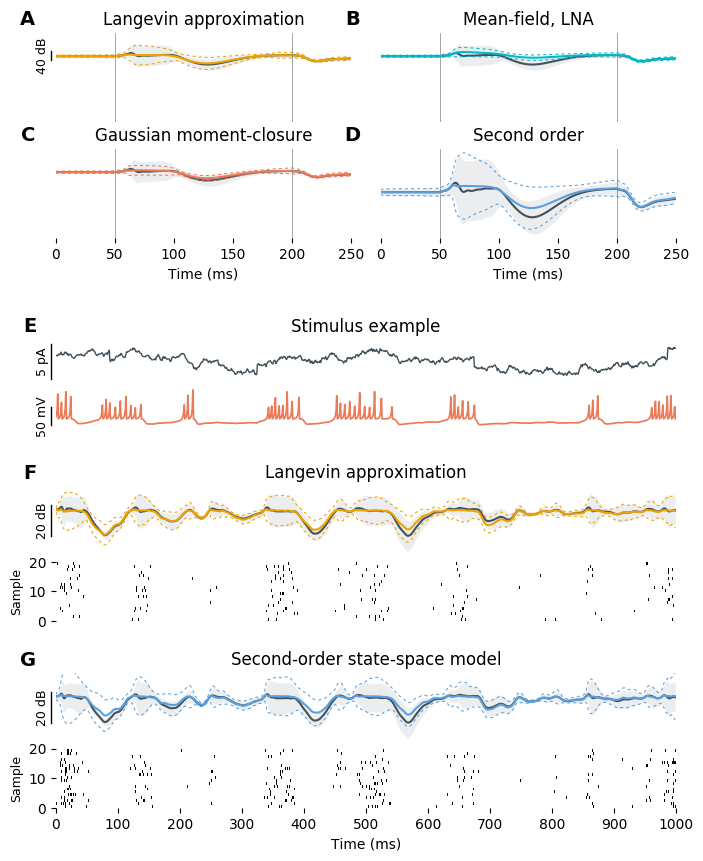

In [16]:
figure(figsize=(8,15))
NROWS = 10
NPLOT = 1000

def stimmarks():
    axvline(padding,color=(0.5,)*3,lw=0.5)
    axvline(npulse-padding,color=(0.5,)*3,lw=0.5)
    
# Plot true sampled GLM against Langevin sampled GLM
subplot2grid((NROWS,2),(0,0),facecolor=(1,1,1,0))
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_lxlv,demo_lvlv,OCHRE,filled=0)
stimmarks(); ylim(*yl); xlim(0,npulse); noxyaxes()
yscalebar(mean(ylim())/dB,40/dB,'40 dB'); 
title('Langevin approximation')
subfigurelabel('A')

# Plot mean-field LNA solution for moments
subplot2grid((NROWS,2),(0,1),facecolor=(1,1,1,0))
stderrplot(demo_lxpp  ,demo_lvpp  ,BLACK,filled=1)
stderrplot(demo_logxmf,demo_logvmf,TURQUOISE,filled=0)
stimmarks(); ylim(*yl); xlim(0,npulse); noxyaxes(); simpleraxis()
title('Mean-field, LNA')
subfigurelabel('B')

# Plot moment closure moments
subplot2grid((NROWS,2),(1,0),facecolor=(1,1,1,0))
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_logxmc,demo_logvmc,RUST,filled=0)
stimmarks(); ylim(*yl); xlim(0,npulse); noy(); noaxis()
xlabel('Time (ms)')
title('Gaussian moment-closure')
subfigurelabel('C')

# Plot second-order approximation
subplot2grid((NROWS,2),(1,1),facecolor=(1,1,1,0))
stderrplot(demo_lxpp  ,demo_lvpp  ,BLACK    ,filled=1)
stderrplot(demo_logxso,demo_logvso,AZURE,filled=0)
stimmarks(); xlim(0,npulse); noy(); noaxis()
yl = (-35,10)
xlabel('Time (ms)')
title('Second order')
subfigurelabel('D')

sc = 20
ax4=subplot2grid((NROWS,2),(2,0),colspan=2,facecolor=(1,1,1,0))
plot(demo_v,color=RUST,lw=1.25)
xlim(0,NPLOT)
yscalebar(min(v)+25,50,'50 mV')
offset = -min(stimulus*sc) + ylim()[1]+30
ss = dstimulus*sc + offset
plot(ss,color=BLACK,lw=1)
yscalebar(mean(ss),sc*5,'5 pA'); 
noxyaxes()
title('Stimulus example')
subfigurelabel('E')

# Plot stimulus
ax5=subplot2grid((NROWS,2),(3,0),colspan=2,facecolor=(1,1,1,0))
stderrplot(lxpp,lvpp,BLACK,filled=1)
# Langevin approximation
stderrplot(logxlv,logvlv,OCHRE,filled=0)
xlim(0,NPLOT); ylim(*yl); yscalebar(mean(ylim()),20,'20 dB'); noxyaxes(); 
title('Langevin approximation')
subfigurelabel('F')

# Plot sampled from Langevin (preserves some autocorrelation)
ax6=subplot2grid((NROWS,2),(4,0),colspan=2,facecolor=(1,1,1,0))
nsamp = 20
p = np.random.poisson(exp(langevin_sample(demo_stim,A,beta,C,M=nsamp)))
pcolormesh(-int32(p.T>0),cmap='gray')
noaxis(); 
nox(); 
ylabel('Sample',fontsize=9); #fudgey(20)

# Plot stimulus
ax7=subplot2grid((NROWS,2),(5,0),colspan=2,facecolor=(1,1,1,0))
stderrplot(lxpp,lvpp,BLACK,filled=1)
stderrplot(logxso,logvso,AZURE,filled=0)
xlim(0,NPLOT); ylim(*yl); yscalebar(mean(ylim()),20,'20 dB'); noxyaxes(); 
title('Second-order state-space model')
subfigurelabel('G')

# Plot sampled from stingle-time marginals (no time correlation)
ax8=subplot2grid((NROWS,2),(6,0),colspan=2,facecolor=(1,1,1,0))
rate = exp(logxso)*(1+0.5*logvso)
p = np.random.poisson(rate[:,None],(len(rate),nsamp))
pcolormesh(-int32(p.T>0),cmap='gray')
noaxis(); 
xticks(arange(0,1001,100)); 
xlabel('Time (ms)'); 
ylabel('Sample',fontsize=9); #fudgey(20)

# Adjust axes location for better design
subplots_adjust(wspace=0.1,hspace=0.3)
nudge_axis_y(-75,ax4)
adjust_axis_height_pixels(20,ax5)
nudge_axis_y(-85,ax5)
adjust_axis_height_pixels(30,ax6)
nudge_axis_y(-35,ax6)
adjust_axis_height_pixels(20,ax7)
nudge_axis_y(-40,ax7)
adjust_axis_height_pixels(30,ax8)
nudge_axis_y(10,ax8)

# Demonstrate estimated likelihood penalty

Moment equations re-interpret the PPGLM as a doubly-stochastic process, and provide a path for detecting mistakes in modelling the *dynamics* of the autoregressive point-process at slow timescales. This could be added to likelihood estimates that capture fast timescales to regularize the estimation of autoregressive PPGLM models for dynamical fidelity.

Note: these are a little different from the main text, please see `ARPPGLM_moment_equations` for the official version.

In [25]:
# Filtered stimulus with offset
stim = m + bhat_stimulus.dot(Bh.T)

# 3000 for a quick demo; Set to len(Y) for proper likelihood
M       = len(Y)
NUSENLL = 3000
print('Estimating likelihood using %d samples'%NUSENLL)

best_nll = -mean(Y[:NUSENLL]*log(1/dt)-Y[:NUSENLL]/dt)
print('Smallest expected NLL is',best_nll*bits)

bits = 1/log(2)
lograte = m + bhat_stimulus.dot(Bh.T)[:M] + bhat_spikehist.dot(By.T)[:M]
glmnll  = -mean(Y*lograte-exp(lograte))
print('GLM nll estimate is',glmnll*bits)

# Use Bayesian filtering to estimate a likelihood using various moment equations
# This likelihood captures the accuracy of the autoregressive point-process
# dynamics at slow timescales, and will penalize the model if the predicted
# dynamics disagree with the data. This additional penalty reflects slow
# timescales. It can be used as a regularizer, but should not be used in 
# isolation without some other method for estimating model likelihood for fast
# timescale effects. 
mfx,mfv,_,_,mfnll = filter_moments(stim[:NUSENLL],Y[:NUSENLL],A,beta,C,m,dt,
            method      = 'LNA',
            measurement = 'moment',
            oversample  = 5,
            int_method  = "approximate_exponential",
            progress    = True)
sox,sov,_,_,sonll = filter_moments(stim[:NUSENLL],Y[:NUSENLL],A,beta,C,m,dt,
            method      = 'second_order',
            measurement = 'moment',
            oversample  = 5,
            int_method  = "approximate_exponential",
            progress    = True)
ggx,ggv,_,_,ggnll = filter_moments(stim[:NUSENLL],Y[:NUSENLL],A,beta,C,m,dt,
            method      = 'approximate_gamma',
            measurement = 'moment',
            oversample  = 5,
            int_method  = "approximate_exponential",
            progress    = True)
mcx,mcv,_,_,mcnll = filter_moments(stim[:NUSENLL],Y[:NUSENLL],A,beta,C,m,dt,
            method      = 'moment_closure',
            measurement = 'moment',
            oversample  = 25, # stiff!
            int_method  = "approximate_exponential",
            progress    = True,
            reg_cov     = 0.0001,
            reg_rate    = 0.001,)
print('\t saturated      nll=  %0.3f'%(best_nll*bits))
print('\t GLM            nll=  %0.3f'%(glmnll*bits))
print('\t mean-field     nll=  %0.3f'%(mfnll*bits))
print('\t moment-closure nll=  %0.3f'%(mcnll*bits))
print('\t second-order   nll=  %0.3f'%(sonll*bits))
print('\t gamma 2-ord    nll=  %0.3f'%(ggnll*bits))
print('\t m.f, nll penalty    %0.3f'%(-(glmnll-mfnll)*bits))
print('\t m.c. nll penalty    %0.3f'%(-(glmnll-mcnll)*bits))
print('\t s.o. nll penalty    %0.3f'%(-(glmnll-sonll)*bits))
print('\t g.g. nll penalty    %0.3f'%(-(glmnll-ggnll)*bits))
print('\t m.f, nll penalty %% %0.3f'%(-(glmnll-mfnll)*100/glmnll))
print('\t m.c. nll penalty %% %0.3f'%(-(glmnll-mcnll)*100/glmnll))
print('\t s.o. nll penalty %% %0.3f'%(-(glmnll-sonll)*100/glmnll))
print('\t g.g. nll penalty %% %0.3f'%(-(glmnll-ggnll)*100/glmnll))
print('\t m.f. nll relative = %0.2f'%((mfnll-glmnll)/(best_nll-glmnll)))
print('\t m.c. nll relative = %0.2f'%((mcnll-glmnll)/(best_nll-glmnll)))
print('\t s.o. nll relative = %0.2f'%((sonll-glmnll)/(best_nll-glmnll)))
print('\t g.g. nll relative = %0.2f'%((ggnll-glmnll)/(best_nll-glmnll)))

Estimating likelihood using 3000 samples
Smallest expected NLL is 0.0163505437967
GLM nll estimate is 0.0412025361253
100.00%
100.00%
100.00%
100.00%
	 saturated      nll=  0.016
	 GLM            nll=  0.041
	 mean-field     nll=  0.063
	 moment-closure nll=  0.070
	 second-order   nll=  0.065
	 gamma 2-ord    nll=  0.064
	 m.f, nll penalty    0.022
	 m.c. nll penalty    0.029
	 s.o. nll penalty    0.024
	 g.g. nll penalty    0.023
	 m.f, nll penalty % 53.883
	 m.c. nll penalty % 70.321
	 s.o. nll penalty % 57.375
	 g.g. nll penalty % 55.172
	 m.f. nll relative = -0.89
	 m.c. nll relative = -1.17
	 s.o. nll relative = -0.95
	 g.g. nll relative = -0.91


## Filtered distributions are similar between methods

The latent intensity distribution is more constrained when conditioned on the data.

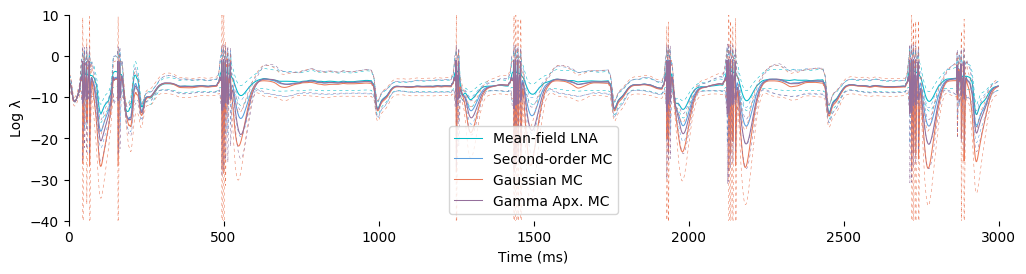

In [26]:
figure()
subplot(211)
stderrplot(mfx,mfv,color=TURQUOISE,lw=.75,label='Mean-field LNA' ,filled=0)
stderrplot(sox,sov,color=AZURE    ,lw=.75,label='Second-order MC',filled=0)
stderrplot(mcx,mcv,color=RUST     ,lw=.75,label='Gaussian MC'    ,filled=0)
stderrplot(ggx,ggv,color=MAUVE    ,lw=.75,label='Gamma Apx. MC'  ,filled=0)
xlim(0,min(NUSENLL,10000))
xlabel('Time (ms)')
ylabel('Log λ')
ylim(-40,10)
simpleraxis()
legend()

# Quantify errors

In [27]:
# Filtered stimulus with offset
stim = m + bhat_stimulus.dot(Bh.T)

# set to 10000 or higher for precise estimate
NSAMPLE = 500 

# "True" sample from point process model
logxpp,logvpp,ratepp,ratevpp = ensemble_sample_moments(stim,B,beta,M=NSAMPLE)
lxpp = box_filter(logxpp,5)
lvpp = box_filter(logvpp,5)
print('Sampled moments from true process')

# Sample from langevin approximation of point process
logxlv,logvlv,expmlv,expvlv  = langevin_sample_moments(stim,A,beta,C,M=NSAMPLE)
lxlv = box_filter(logxlv,5)
lvlv = box_filter(logvlv,5)
print('Sampled moments from Langevin process')

# resample from point process model to guage variability
# (proxy for the amount of error in error estimate)
# if the error between successive monte-carlo estimates of the true moments
# is larger than the desired precision, increase NSAMPLE
logxpp2,logvpp2,ratepp2,ratevpp2 = ensemble_sample_moments(stim,B,beta,M=NSAMPLE)
lxpp2 = box_filter(logxpp2,5)
lvpp2 = box_filter(logvpp2,5)
print('Sampled moments from true process (again, to gauge variability)')

Sampled moments from true process
Sampled moments from Langevin process
Sampled moments from true process (again, to gauge variability)


## Estimate moments using various methods

In [28]:
logxso,logvso,_,_ = integrate_moments(stim,A,beta,C,
                                            method     = "second_order",
                                            int_method = "approximate_exponential",
                                            oversample = 5)
print('Integrated second-order moment equations')

logxmc,logvmc,_,_ = integrate_moments(stim,A,beta,C,
                                            method     = "moment_closure",
                                            int_method = "approximate_exponential",
                                            oversample = 15)
print('Integrated Gaussian moment-closure equations')

logxmf,logvmf,_,_ = integrate_moments(stim,A,beta,C,
                                            method     = "LNA",
                                            int_method = "approximate_exponential",
                                            oversample = 5)
print('Integrated Linear Noise Approximation (LNA) moment equations')

logxgg,logvgg,_,_ = integrate_moments(stim,A,beta,C,
                                            method     = "approximate_gamma",
                                            int_method = "approximate_exponential",
                                            oversample = 5)
print('Integrated Approximate Gamma MC moment equations')

Integrated second-order moment equations
Integrated Gaussian moment-closure equations
Integrated Linear Noise Approximation (LNA) moment equations
Integrated Approximate Gamma MC moment equations


## Calculate normalized RMSE

In [29]:
def error(estimate,true):
    err  = sqrt(mean((estimate-true)**2)/var(true))
    return err

# Make sure these are not too large
# increase NSAMPLE if they are
# (NSAMPLE has been decreased for quick demonstration)
print('Point-process sampling variability, nomalized RMSE')
print('\tLog mean-rate','%0.2f'%error(log(ratepp2),log(ratepp)))
print('\tLog-rate mean','%0.2f'%error(lxpp2,lxpp))
print('\tLog-rate σ   ','%0.2f'%error(lvpp2**0.5,lvpp**0.5))

print('Langevin, normalized RMSE')
print('\tLog mean-rate','%0.2f'%error(log(expmlv),log(ratepp)))
print('\tLog-rate mean','%0.2f'%error(logxlv,lxpp))
print('\tLog-rate σ   ','%0.2f'%error(logvlv**0.5,lvpp**0.5))

print('Mean-field + LNA, normalized RMSE')
print('\tLog mean-rate','%0.2f'%error(logxmf,log(ratepp)))
print('\tLog-rate mean','%0.2f'%error(logxmf,lxpp))
print('\tLog-rate σ   ','%0.2f'%error(logvmf**0.5,lvpp**0.5))

print('Moment-Closure, normalized RMSE')
print('\tlog mean-rate','%0.2f'%error(log(exp(logxmc+0.5*logvmc)),log(ratepp)))
print('\tLog-rate mean','%0.2f'%error(logxmc,lxpp))
print('\tLog-rate σ   ','%0.2f'%error(logvmc**0.5,lvpp**0.5))

print('Second-Order, normalized RMSE')
print('\tlog mean-rate','%0.2f'%error(log(exp(logxso)*(1+0.5*logvso)),log(ratepp)))
print('\tLog-rate mean','%0.2f'%error(logxso,lxpp))
print('\tLog-rate σ   ','%0.2f'%error(logvso**0.5,lvpp**0.5))

print('Approximate gamma, normalized RMSE')
print('\tlog mean-rate','%0.2f'%error(log(exp(logxgg)*robust_expgammameancorrection(logvgg)),log(ratepp)))
print('\tLog-rate mean','%0.2f'%error(logxgg,lxpp))
print('\tLog-rate σ   ','%0.2f'%error(logvgg**0.5,lvpp**0.5))

Point-process sampling variability, nomalized RMSE
	Log mean-rate 0.09
	Log-rate mean 0.03
	Log-rate σ    0.16
Langevin, normalized RMSE
	Log mean-rate 0.36
	Log-rate mean 0.19
	Log-rate σ    0.41
Mean-field + LNA, normalized RMSE
	Log mean-rate 0.32
	Log-rate mean 0.72
	Log-rate σ    0.79
Moment-Closure, normalized RMSE
	log mean-rate 0.36
	Log-rate mean 0.26
	Log-rate σ    0.74
Second-Order, normalized RMSE
	log mean-rate 0.23
	Log-rate mean 0.31
	Log-rate σ    0.51
Approximate gamma, normalized RMSE
	log mean-rate 0.29
	Log-rate mean 0.16
	Log-rate σ    1.00


## Error spectra: observe timescale of accuracy

Assumes dt = 1ms

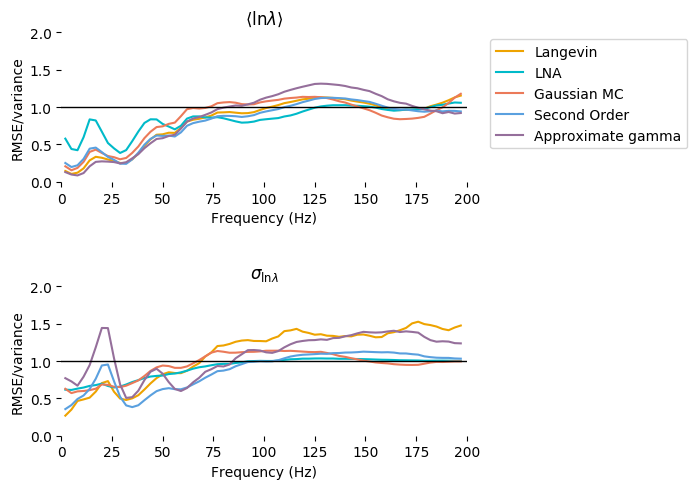

In [30]:
def banderror(estimate,true,low,high):
    '''
    Get normalized RMSE within specified frequency range
    '''
    estimate = bandpass_filter(estimate,low,high)
    true     = bandpass_filter(true,low,high)
    err      = sqrt(mean((estimate-true)**2)/var(true))
    return err

def errorspectrum(estimate,true,bands,width):
    '''
    Sweep a range of frequencies and estimate normalized RMSE
    within each band. This will reveal the timescales at which
    the approximations are accurate. 
    '''
    totalerr = error(estimate,true)
    return array([banderror(estimate,true,f,f+width) for f in bands])

MAXF  = 200              # Highest frequency to check
bands = arange(2,MAXF,3) # Lower edges of bands to check
width = 10               # Width of bands to check

figure(figsize=(5,5))

subplot(211)
plot(bands,errorspectrum(logxlv,logxpp,bands,width),label='Langevin',color=OCHRE)
plot(bands,errorspectrum(logxmf,logxpp,bands,width),label='LNA',color=TURQUOISE)
plot(bands,errorspectrum(logxmc,logxpp,bands,width),label='Gaussian MC',color=RUST)
plot(bands,errorspectrum(logxso,logxpp,bands,width),label='Second Order',color=AZURE)
plot(bands,errorspectrum(logxgg,logxpp,bands,width),label='Approximate gamma',color=MAUVE)
xlim(0,MAXF)
ylim(0,2)
axhline(1,color='k',lw=1)
noaxis()
xlabel('Frequency (Hz)')
ylabel('RMSE/variance')
legend(bbox_to_anchor=(1.04,1), loc="upper left")
title(r'$\left<\ln \lambda \right>$')

subplot(212)
plot(bands,errorspectrum(logvlv**0.5,logvpp**0.5,bands,width),label='Langevin',color=OCHRE)
plot(bands,errorspectrum(logvmf**0.5,logvpp**0.5,bands,width),label='LNA',color=TURQUOISE)
plot(bands,errorspectrum(logvmc**0.5,logvpp**0.5,bands,width),label='Gaussian MC',color=RUST)
plot(bands,errorspectrum(logvso**0.5,logvpp**0.5,bands,width),label='Second Order',color=AZURE)
plot(bands,errorspectrum(logvgg**0.5,logvpp**0.5,bands,width),label='Approximate gamma',color=MAUVE)
xlim(0,MAXF)
ylim(0,2)
axhline(1,color='k',lw=1)
noaxis()
xlabel('Frequency (Hz)')
ylabel('RMSE/variance')
title('$\sigma_{\ln \lambda}$')

tight_layout()
subplots_adjust(hspace=0.7)

## Measure slow-timescale accuracy

These are broadly similar to the accuracies estimated using the full bandwidth, because most of the power in the original point-process is concentrated at low frequencies. 

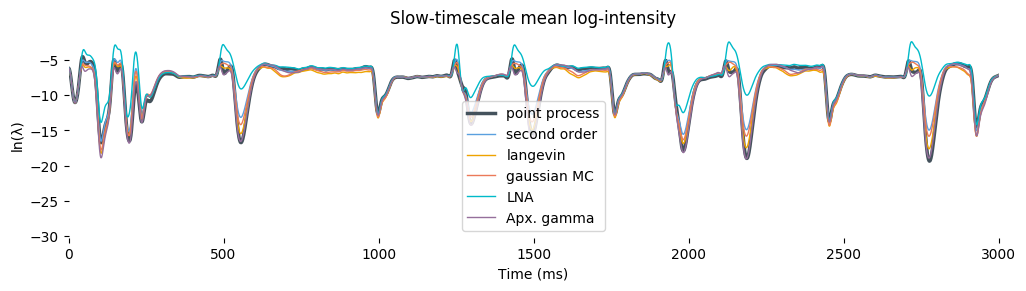

Reporting RMSE with low-frequency cutoff of 50 Hz (slow timescales)
Point-process sampling variability, nomalized RMSE
	Log mean-rate 0.07
	Log-rate mean 0.02
	Log-rate σ    0.12
Langevin, normalized RMSE
	Log mean-rate 0.32
	Log-rate mean 0.18
	Log-rate σ    0.37
Mean-field + LNA, normalized RMSE
	Log mean-rate 0.32
	Log-rate mean 0.72
	Log-rate σ    0.79
Moment-Closure, normalized RMSE
	log mean-rate 0.36
	Log-rate mean 0.25
	Log-rate σ    0.74
Second-Order, normalized RMSE
	log mean-rate 0.23
	Log-rate mean 0.31
	Log-rate σ    0.51
Approximate gamma, normalized RMSE
	log mean-rate 0.29
	Log-rate mean 0.15
	Log-rate σ    1.00


In [31]:
cutoff = 50

def error(estimate,true):
    ''' Normalized RMSE, but apply low-frequency cutodd'''
    estimate = bandpass_filter(estimate,None,cutoff)
    true     = bandpass_filter(true,None,cutoff)
    err      = sqrt(mean((estimate-true)**2)/var(true))
    return err

# Plot slow timescale mean log intensity
subplot(211)
plot(bandpass_filter(logxpp,None,cutoff),lw=2.5,color=BLACK,label='point process')
plot(bandpass_filter(logxso,None,cutoff),lw=1,color=AZURE,label='second order')
plot(bandpass_filter(logxlv,None,cutoff),lw=1,color=OCHRE,label='langevin')
plot(bandpass_filter(logxmc,None,cutoff),lw=1,color=RUST,label='gaussian MC')
plot(bandpass_filter(logxmf,None,cutoff),lw=1,color=TURQUOISE,label='LNA')
plot(bandpass_filter(logxgg,None,cutoff),lw=1,color=MAUVE,label='Apx. gamma')
xlim(0,NUSENLL)
noaxis()
xlabel('Time (ms)')
ylabel('ln(λ)')
legend()
title('Slow-timescale mean log-intensity')
show()

# Report normalized RMSE focused on slow timescales
print('Reporting RMSE with low-frequency cutoff of %d Hz (slow timescales)'%50)

print('Point-process sampling variability, nomalized RMSE')
print('\tLog mean-rate','%0.2f'%error(log(ratepp2),log(ratepp)))
print('\tLog-rate mean','%0.2f'%error(lxpp2,lxpp))
print('\tLog-rate σ   ','%0.2f'%error(lvpp2**0.5,lvpp**0.5))

print('Langevin, normalized RMSE')
print('\tLog mean-rate','%0.2f'%error(log(expmlv),log(ratepp)))
print('\tLog-rate mean','%0.2f'%error(logxlv,lxpp))
print('\tLog-rate σ   ','%0.2f'%error(logvlv**0.5,lvpp**0.5))

print('Mean-field + LNA, normalized RMSE')
print('\tLog mean-rate','%0.2f'%error(logxmf,log(ratepp)))
print('\tLog-rate mean','%0.2f'%error(logxmf,lxpp))
print('\tLog-rate σ   ','%0.2f'%error(logvmf**0.5,lvpp**0.5))

print('Moment-Closure, normalized RMSE')
print('\tlog mean-rate','%0.2f'%error(log(exp(logxmc+0.5*logvmc)),log(ratepp)))
print('\tLog-rate mean','%0.2f'%error(logxmc,lxpp))
print('\tLog-rate σ   ','%0.2f'%error(logvmc**0.5,lvpp**0.5))

print('Second-Order, normalized RMSE')
print('\tlog mean-rate','%0.2f'%error(log(exp(logxso)*(1+0.5*logvso)),log(ratepp)))
print('\tLog-rate mean','%0.2f'%error(logxso,lxpp))
print('\tLog-rate σ   ','%0.2f'%error(logvso**0.5,lvpp**0.5))

print('Approximate gamma, normalized RMSE')
print('\tlog mean-rate','%0.2f'%error(log(exp(logxgg)*robust_expgammameancorrection(logvgg)),log(ratepp)))
print('\tLog-rate mean','%0.2f'%error(logxgg,lxpp))
print('\tLog-rate σ   ','%0.2f'%error(logvgg**0.5,lvpp**0.5))

## Best of both worlds

This is unorthodox, but for illustration: combine the Gamma moment closure, which gives a very accurate estimate of the mean, with the second-order Gaussian moment-closure, which gives a very accurate estimate of the variance. 

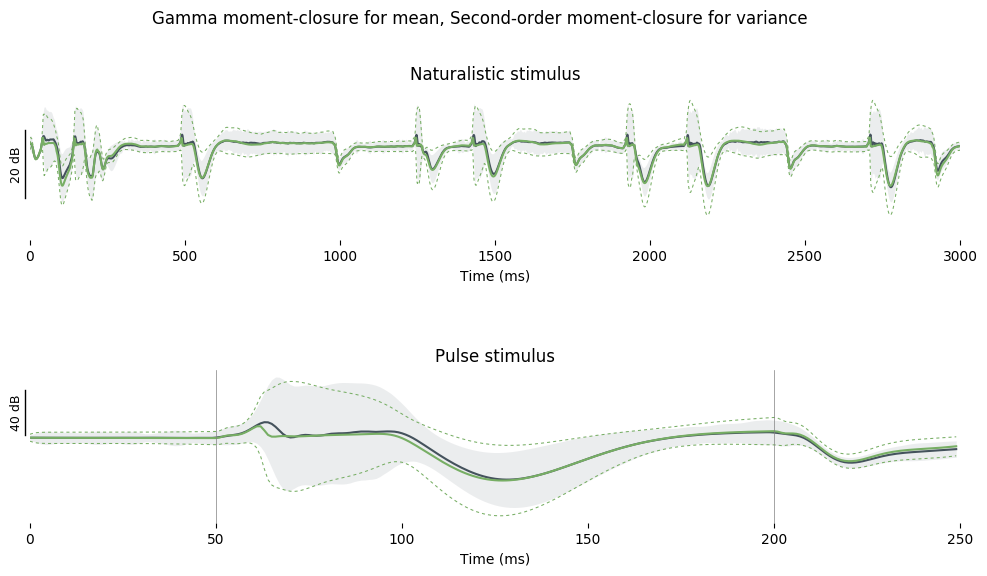

In [32]:
figure(figsize=(12,6))
NPLOT = 3000
subplot(211)
stderrplot(lxpp,lvpp,BLACK,filled=1)
stderrplot(logxgg,logvso,GREEN,filled=0)
xlim(0,NPLOT); 
ylim(*yl); 
yscalebar(mean(ylim()),20,'20 dB'); 
noy()
noaxis()
xlabel('Time (ms)')
title('Naturalistic stimulus')

subplot(212)
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_logxgg,demo_logv, GREEN,filled=0)
xlim(0,npulse)
noaxis()
title('Pulse stimulus')
xlabel('Time (ms)')
stimmarks();
yscalebar(mean(ylim())/dB,40/dB,'40 dB'); 
noy()

subplots_adjust(hspace=0.85,top=0.85)
suptitle('Gamma moment-closure for mean, Second-order moment-closure for variance')
